In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from IPython.display import display, Audio
from utils.utils import utils
utils = utils()

# Get the data from https://www.kaggle.com/kongaevans/speaker-recognition-dataset/download
DATASET_ROOT = "./16000_pcm_speeches"

# The folders in which we will put the audio samples and the noise samples
AUDIO_SUBFOLDER = "audio"
NOISE_SUBFOLDER = "noise"
DATASET_AUDIO_PATH = os.path.join(DATASET_ROOT, AUDIO_SUBFOLDER)
DATASET_NOISE_PATH = os.path.join(DATASET_ROOT, NOISE_SUBFOLDER)

VALID_SPLIT = 0.1 # Percentage of samples to use for validation
SHUFFLE_SEED = 43 # Seed to use when shuffling the dataset and the noise

# The sampling rate toresample at. Also the output size of audio files (1 second)
SAMPLING_RATE = 16000

# The factor to multiply the noise with according to:
#   noisy_sample = sample + noise * prop * scale
#      where prop = sample_amplitude / noise_amplitude
SCALE = 0.5

In [2]:
# If folder `audio`, does not exist, create it, otherwise do nothing
if os.path.exists(DATASET_AUDIO_PATH) is False:
    os.makedirs(DATASET_AUDIO_PATH)

# If folder `noise`, does not exist, create it, otherwise do nothing
if os.path.exists(DATASET_NOISE_PATH) is False:
    os.makedirs(DATASET_NOISE_PATH)

for folder in os.listdir(DATASET_ROOT):
    if os.path.isdir(os.path.join(DATASET_ROOT, folder)):
        if folder in [AUDIO_SUBFOLDER, NOISE_SUBFOLDER]:
            # If folder is `audio` or `noise`, do nothing
            continue
        elif folder in ["other", "_background_noise_"]:
            # If folder is one of the folders that contains noise samples,
            # move it to the `noise` folder
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_NOISE_PATH, folder),
            )
        else:
            # Otherwise, it should be a speaker folder, then move it to
            # `audio` folder
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_AUDIO_PATH, folder),
            )

In [3]:
# For each noise file (files in DATASET_NOISE_PATH, ending with .wav)
# Stack into a list - noises
noises = []
noise_paths = utils.get_noise_paths(DATASET_NOISE_PATH, ending=".wav")
for path in noise_paths:
    os.system("ffmpeg -i " + path + " -ar 16000 " + path + "temp.wav")
    os.remove(path)
    os.rename(path + "temp.wav", path)
    
    sample = utils.load_noise_sample(path, SAMPLING_RATE)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

print(
    "{} noise files were split into {} noise samples where each is {} sec. long".format(
        len(noise_paths), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

Found 6 files belonging to 2 directories
61 slices, [<tf.Tensor: shape=(16000, 1), dtype=float32, numpy=
array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       ...,
       [-0.00695801],
       [ 0.00799561],
       [ 0.0350647 ]], dtype=float32)>, <tf.Tensor: shape=(16000, 1), dtype=float32, numpy=
array([[ 0.02267456],
       [ 0.02301025],
       [ 0.03671265],
       ...,
       [ 0.04626465],
       [ 0.01608276],
       [-0.00585938]], dtype=float32)>, <tf.Tensor: shape=(16000, 1), dtype=float32, numpy=
array([[ 0.0272522 ],
       [ 0.00085449],
       [-0.02471924],
       ...,
       [ 0.0274353 ],
       [ 0.00796509],
       [ 0.02160645]], dtype=float32)>, <tf.Tensor: shape=(16000, 1), dtype=float32, numpy=
array([[ 0.01400757],
       [ 0.03594971],
       [ 0.04772949],
       ...,
       [ 0.01580811],
       [-0.02340698],
       [-0.00744629]], dtype=float32)>, <tf.Tensor: shape=(16000, 1), dtype=float32, numpy=
array([[ 0.0241394 ],
       [ 0.001190

In [4]:
BATCH_SIZE = 8
EPOCHS = 100

# Get the list of audio file paths along with their corresponding labels
class_names = os.listdir(DATASET_AUDIO_PATH)
print("Our class names: {}".format(class_names,))

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print("Processing speaker {}".format(name,))
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng.shuffle(labels)

# Split into training and validation
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

# Create 2 datasets, one for training and the other for validation
train_ds = utils.paths_and_labels_to_dataset(train_audio_paths, train_labels, SAMPLING_RATE)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = utils.paths_and_labels_to_dataset(valid_audio_paths, valid_labels, SAMPLING_RATE)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)

# Add noise to the training set
train_ds = train_ds.map(
    lambda x, y: (utils.add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

Our class names: ['Benjamin_Netanyau', 'Jens_Stoltenberg', 'Julia_Gillard', 'Magaret_Tarcher', 'Nelson_Mandela']
Processing speaker Benjamin_Netanyau
Processing speaker Jens_Stoltenberg
Processing speaker Julia_Gillard
Processing speaker Magaret_Tarcher
Processing speaker Nelson_Mandela
Found 7501 files belonging to 5 classes.
Using 6751 files for training.
Using 750 files for validation.


In [5]:
def residual_block(x, filters, conv_num=3, kernel_size = 3,activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, kernel_size, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, kernel_size, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 128, 2, 20)
    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = residual_block(x, 64, 2, 8)
    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = residual_block(x, 64, 2, 4)
    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = residual_block(x, 32, 2, 4)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE, 1), len(class_names))
# model = build_model((SAMPLING_RATE // 2, 1), len(class_names))

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 16000, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 16000, 128)   2688        input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 128)   0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 16000, 128)   327808      activation[0][0]                 
______________________________________________________________________________________________

In [20]:
from WaveNetClassifier import WaveNetClassifier
wnc = WaveNetClassifier((16000,), (5,), kernel_size = 2, dilation_depth = 9, n_filters = 40, task = 'classification')

y = np.concatenate([y for x, y in train_ds], axis=0)
y = tf.keras.utils.to_categorical(y-1, num_classes = 5)

x = np.concatenate([x for x, y in train_ds], axis=0)
y_val = np.concatenate([y for x, y in valid_ds], axis=0)
y_val = tf.keras.utils.to_categorical(y_val-1, num_classes = 5)
x_val = np.concatenate([x for x, y in valid_ds], axis=0)
# y_test = np.concatenate([y for x, y in test_ds], axis=0)
# x_test = np.concatenate([x for x, y in test_ds], axis=0)

# print(np.shape(y))
# print(np.shape(x))
history = wnc.fit(x, y, validation_data = (x_val, y_val), epochs = 100, batch_size = 8, optimizer='adam', save=True, save_dir='./')
# y_pred = wnc.predict(x_test)


Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
original_input (InputLayer)     [(None, 16000)]      0                                            
__________________________________________________________________________________________________
reshaped_input (Reshape)        (None, 16000, 1)     0           original_input[0][0]             
__________________________________________________________________________________________________
dilated_conv_1 (Conv1D)         (None, 16000, 40)    120         reshaped_input[0][0]             
__________________________________________________________________________________________________
dilated_conv_2_tanh (Conv1D)    (None, 16000, 40)    3240        dilated_conv_1[0][0]             
___________________________________________________________________________________________

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


623/844 [=====================>........] - ETA: 58s - loss: 1.6096 - accuracy: 0.2014

In [ ]:

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)   

Epoch 1/100


C:\ProgramData\Miniconda3\envs\usc39\lib\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_6/IntPol_5/sub:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_6/IntPol_5/GatherV2_2:0", shape=(None, None, 1, 48), dtype=float32), dense_shape=Tensor("gradient_tape/model_6/IntPol_5/Shape_1:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\usc39\lib\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_6/IntPol_5/sub_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_6/IntPol_5/GatherV2_5:0", shape=(None, None, 1, 48), dtype=float32), dense_shape=Tensor("gradient_tape/model_6/IntPol_5/Shape_2:0", shape=(4,), dtype=int32))) to a dense Tenso

808/844 [===========================>..] - ETA: 4s - loss: 47.7806 - diff_out_loss: 9.5540 - diff_out_1_loss: 9.5540 - diff_out_2_loss: 9.5540 - diff_out_3_loss: 9.5540 - diff_out_4_loss: 9.5650 - diff_out_accuracy: 0.2010 - diff_out_1_accuracy: 0.2010 - diff_out_2_accuracy: 0.2010 - diff_out_3_accuracy: 0.2010 - diff_out_4_accuracy: 0.1988

KeyboardInterrupt: 

0.184

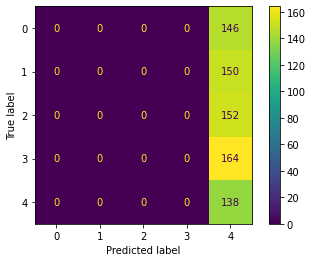

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
SAMPLES_TO_DISPLAY = 10

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

y_preds_, labels_ = [], []
for audios, labels in test_ds.take(1000):
    y_pred = model.predict(audios)
    
    # Take random samples
    audios = audios.numpy()
    labels = labels.numpy()
    y_pred = np.argmax(y_pred, axis=-1)
    labels_.append(labels)
    y_preds_.append(y_pred)

y_preds_ = [item for sublist in y_preds_ for item in sublist]
labels_ = [item for sublist in labels_ for item in sublist]
cm = ConfusionMatrixDisplay.from_predictions(labels_, y_preds_)
accuracy_score(labels_, y_preds_)
# cm.figure_.savefig(os.path.join(conf_mat_path, "fold_" + str(test_index[0]) + '_acc_' + str(accuracy_score(y_true, y_pred))) + '.png',dpi=1000)


In [ ]:
SAMPLES_TO_DISPLAY = 10

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

for audios, labels in test_ds.take(1):
    # Get the signal FFT
    # ffts = audio_to_fft(audios)

    # Predict
    # y_pred = model.predict(ffts)
    y_pred = model.predict(audio)
    
    # Take random samples
    rnd = np.random.randint(0, BATCH_SIZE, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):
        # For every sample, print the true and predicted label
        # as well as run the voice with the noise
        print(
            "Speaker: {} - Predicted: {}".format(
                class_names[labels[index]],
                class_names[y_pred[index]],
            )
        )
        display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

NameError: name 'audio' is not defined